In [1]:
### Python
import os
import random
import time
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from math import ceil

### Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data
import segmentation_models_pytorch as smp
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchsummary import summary

### Others
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

### Images
import cv2
from PIL import Image

#my classes
import dataset as customdataset
import my_functions
import models

ModuleNotFoundError: No module named 'torch'

In [3]:
! conda install pytorch torchvision -c pytorch

^C


In [2]:
# Set seeds for reproducibility (PyTorch, Python, Numpy)
matricola = 2013031
torch.manual_seed(matricola)
random.seed(matricola)
np.random.seed(matricola)

In [3]:
path = "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn_kenel_counting_dataset/corn_kenel_counting_dataset/"

categorie = "corn"

train_csv_positions  = path + f"{categorie}_coco/{categorie}_kernel_train_positions.csv" 
train_csv_info       = path + f"{categorie}_coco/{categorie}_kernel_train_info.csv"
train_data_path = path + f"{categorie}_coco" 

test_csv_positions  = path + f"{categorie}_coco/{categorie}_kernel_test_positions.csv" 
test_csv_info       = path + f"{categorie}_coco/{categorie}_kernel_test_info.csv"
test_data_path = path + f"{categorie}_coco" 

In [4]:
### Define dataset
train_dataset = customdataset.CustomImageDataset(train_csv_positions,train_csv_info,train_data_path,
                                           threshold=1e-4,re_scale=1e5,
                                           img_transforms=transforms.ToTensor(),
                                           mask_transforms=transforms.ToTensor(),
                                           I_M_transforms=None)

test_dataset = customdataset.CustomImageDataset(test_csv_positions,test_csv_info,test_data_path,
                                           threshold=1e-4,re_scale=1e5,
                                           img_transforms=transforms.ToTensor(),
                                           mask_transforms=transforms.ToTensor(),
                                           I_M_transforms=None)

In [5]:
print("max",train_dataset[0][0].amax(axis= [1,2]))
print("min",train_dataset[0][0].amin(axis= [1,2]))

train_mean, train_std = my_functions.dataset_mean_std(train_dataset)
# Mean and std should be divided by 255 (maximum pixel value)
# because, after the ToTensor() transformation (see next step), images are normalized
# between 0 and 1.
#train_mean, train_std =train_mean/255, train_std/255
# output
print('mean: '  + str(train_mean))
print('std:  '  + str(train_std))

max tensor([1., 1., 1.])
min tensor([0., 0., 0.])
mean: tensor([0.5070, 0.4383, 0.3099])
std:  tensor([0.2985, 0.2740, 0.2705])


In [6]:
# Split train data into train and validation sets
# (10% of training set will be used as validation set)
num_train_examples = int(len(train_dataset) * 0.80)
num_valid_examples = len(train_dataset) - num_train_examples

print(f"Number of training examples: {num_train_examples}")

Number of training examples: 193


In [7]:
# Create 'Subset' objects
train_dataset, validation_dataset = data.random_split(train_dataset, [num_train_examples, num_valid_examples])

print(f"Number training examples: {len(train_dataset)}")
print(f"Number validation examples: {len(validation_dataset)}")
print(f"Number test examples: {len(test_dataset)}")

Number training examples: 193
Number validation examples: 49
Number test examples: 62


In [8]:
# Apply test transformations to the validation set
validation_dataset = copy.deepcopy(validation_dataset) # If we change train transformations, this won't affect the validation set


In [9]:
### Define the data augmentation transforms
### and also the pretrained model standards for Imagenet
# https://discuss.pytorch.org/t/how-to-preprocess-input-for-pre-trained-networks/683/2
# mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]

train_img_transforms = transforms.Compose([
                                        torchvision.transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                        torchvision.transforms.RandomAutocontrast(p=0.4),
                                        torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0.1, hue=0.1),
                                        transforms.Resize((320,320)),
                                        ])

train_geometric_transforms = transforms.Compose([
                                           #customdataset.padding(384,640),
                                           #customdataset.Random_Cropping(384,640),
                                           customdataset.MyRotations(),
                                          ])
test_validation_geometric_transforms = transforms.Compose([
                                           #customdataset.padding(384,640),
                                           #customdataset.Random_Cropping(384,640),
                                          ])
test_validation_img_transforms = transforms.Compose([
                                                     torchvision.transforms.ToTensor(),
                                                     #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                                     transforms.Resize((320,320)),
                                                     ])

lbl_transforms = transforms.Compose([
                                     torchvision.transforms.ToTensor(),
                                     transforms.Resize((320,320)),
                                     ])

In [10]:
### Update transforms for the datasets and the corresponding iterators
# Train dataset
train_dataset.dataset.I_M_transforms    = train_geometric_transforms
train_dataset.dataset.img_transforms    = train_img_transforms
train_dataset.dataset.mask_transforms   = lbl_transforms
train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True, num_workers=0)

# Validation dataset
validation_dataset.dataset.I_M_transforms    = test_validation_geometric_transforms
validation_dataset.dataset.img_transforms    = test_validation_img_transforms
validation_dataset.dataset.mask_transforms   = lbl_transforms
validation_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False, num_workers=0)

# test dataset
test_dataset.I_M_transforms    = test_validation_geometric_transforms
test_dataset.img_transforms    = test_validation_img_transforms
test_dataset.mask_transforms = lbl_transforms
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)


Training dataloader 

In [11]:
start_time = time.time()
train_images, train_masks, shape,count = next(iter(train_dataloader))
end_time = time.time()
print(f"Dataloader Time: {end_time-start_time:.2f} s")

Dataloader Time: 26.68 s


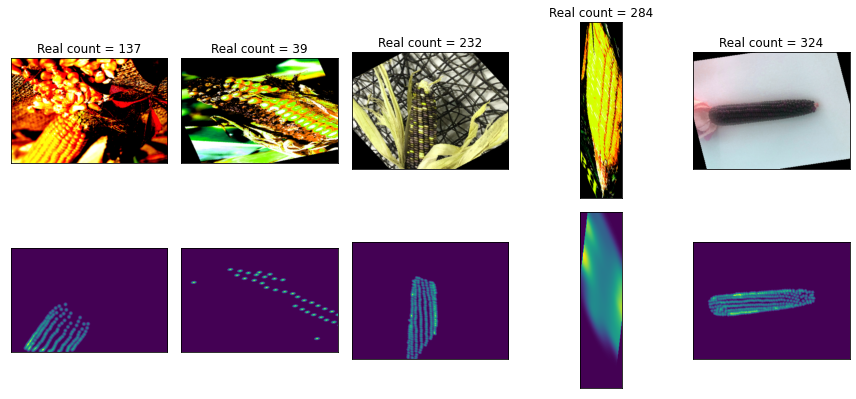

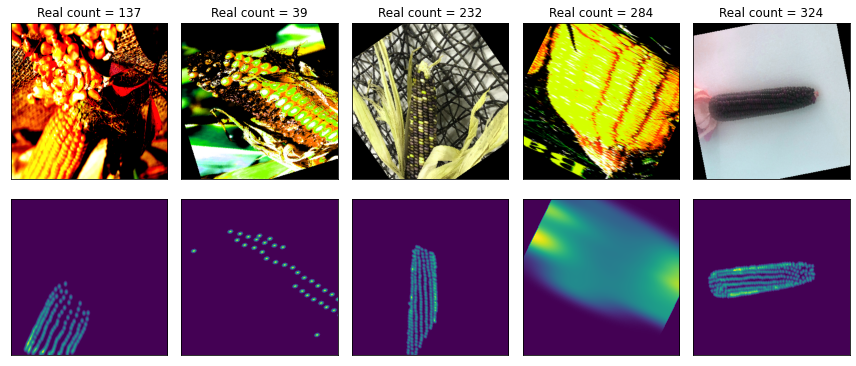

In [12]:
my_functions.reconstruct_plot_images_masks(train_images, train_masks, shape,count)
my_functions.Non_reconstruct_plot_images_masks(train_images, train_masks, shape,count)

Validation dataloader

In [13]:
start_time = time.time()
validation_images, validation_masks, shape,count = next(iter(validation_dataloader))
end_time = time.time()
print(f"Dataloader Time: {end_time-start_time:.2f} s")

Dataloader Time: 10.79 s


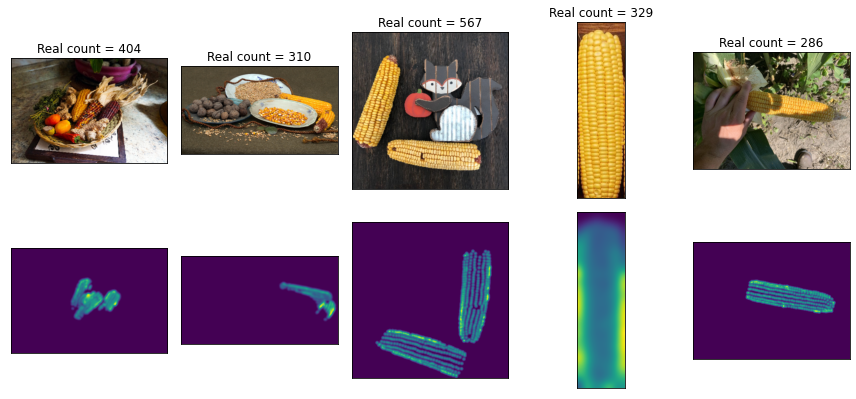

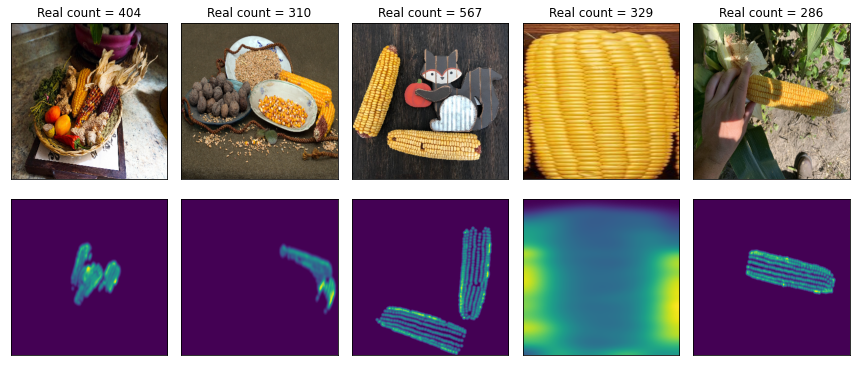

In [15]:
my_functions.reconstruct_plot_images_masks(validation_images, validation_masks, shape,count)
my_functions.Non_reconstruct_plot_images_masks(validation_images, validation_masks, shape,count)

Test dataloader

In [16]:
start_time = time.time()
test_images, test_masks, shape,count = next(iter(test_dataloader))
end_time = time.time()
print(f"Dataloader Time: {end_time-start_time:.2f} s")

Dataloader Time: 14.13 s


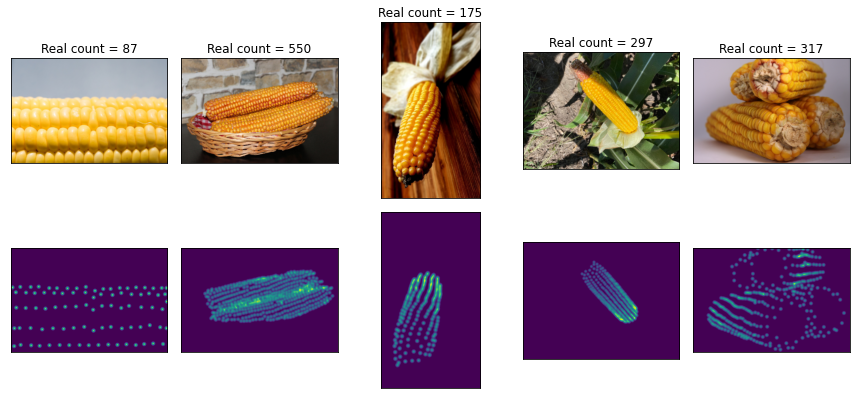

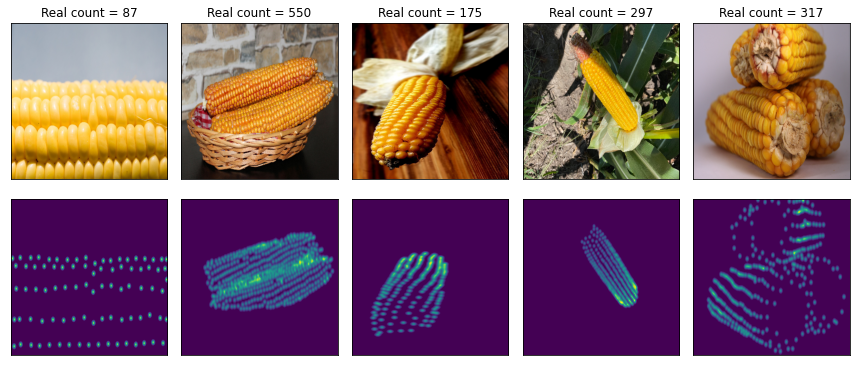

In [17]:
my_functions.reconstruct_plot_images_masks(test_images, test_masks, shape,count)
my_functions.Non_reconstruct_plot_images_masks(test_images, test_masks, shape,count)

# Architecture

In [18]:
###############
# VGG
###############

### Load pretrained model
VGG16 = smp.Unet('vgg16', encoder_weights='imagenet')
### Define the model
model = VGG16

In [18]:
###############
# mobilenet_v2
###############

### Load pretrained model
MOBILENET = smp.Unet('mobilenet_v2', encoder_weights='imagenet')
### Define the model
model = MOBILENET#models.Map_CNN(backbone)

In [23]:
###############
# efficientnet-b1
###############

### Load pretrained model
EFFICIENTNET = smp.Unet('efficientnet-b1', encoder_weights='imagenet')
### Define the model
model = EFFICIENTNET#models.Map_CNN(backbone)

In [19]:
summary(model, (3, 320, 320))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 160, 160]             864
       BatchNorm2d-2         [-1, 32, 160, 160]              64
             ReLU6-3         [-1, 32, 160, 160]               0
            Conv2d-4         [-1, 32, 160, 160]             288
       BatchNorm2d-5         [-1, 32, 160, 160]              64
             ReLU6-6         [-1, 32, 160, 160]               0
            Conv2d-7         [-1, 16, 160, 160]             512
       BatchNorm2d-8         [-1, 16, 160, 160]              32
  InvertedResidual-9         [-1, 16, 160, 160]               0
           Conv2d-10         [-1, 96, 160, 160]           1,536
      BatchNorm2d-11         [-1, 96, 160, 160]             192
            ReLU6-12         [-1, 96, 160, 160]               0
           Conv2d-13           [-1, 96, 80, 80]             864
      BatchNorm2d-14           [-1, 96,

In [20]:
### Disable the weight update for the trained encoder
for param_name, param in model.encoder.named_parameters():
    param.requires_grad = False

### Allow weight update (training) of the last layers (linear layers)
for param in model.decoder.parameters():
    param.requires_grad = True

### Check which weights and biases will be updated
for param_name, param in model.named_parameters():
    print(param_name,param.requires_grad)

encoder.features.0.0.weight False
encoder.features.0.1.weight False
encoder.features.0.1.bias False
encoder.features.1.conv.0.0.weight False
encoder.features.1.conv.0.1.weight False
encoder.features.1.conv.0.1.bias False
encoder.features.1.conv.1.weight False
encoder.features.1.conv.2.weight False
encoder.features.1.conv.2.bias False
encoder.features.2.conv.0.0.weight False
encoder.features.2.conv.0.1.weight False
encoder.features.2.conv.0.1.bias False
encoder.features.2.conv.1.0.weight False
encoder.features.2.conv.1.1.weight False
encoder.features.2.conv.1.1.bias False
encoder.features.2.conv.2.weight False
encoder.features.2.conv.3.weight False
encoder.features.2.conv.3.bias False
encoder.features.3.conv.0.0.weight False
encoder.features.3.conv.0.1.weight False
encoder.features.3.conv.0.1.bias False
encoder.features.3.conv.1.0.weight False
encoder.features.3.conv.1.1.weight False
encoder.features.3.conv.1.1.bias False
encoder.features.3.conv.2.weight False
encoder.features.3.conv.3.

In [21]:
summary(model, (3, 320, 320))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 160, 160]             864
       BatchNorm2d-2         [-1, 32, 160, 160]              64
             ReLU6-3         [-1, 32, 160, 160]               0
            Conv2d-4         [-1, 32, 160, 160]             288
       BatchNorm2d-5         [-1, 32, 160, 160]              64
             ReLU6-6         [-1, 32, 160, 160]               0
            Conv2d-7         [-1, 16, 160, 160]             512
       BatchNorm2d-8         [-1, 16, 160, 160]              32
  InvertedResidual-9         [-1, 16, 160, 160]               0
           Conv2d-10         [-1, 96, 160, 160]           1,536
      BatchNorm2d-11         [-1, 96, 160, 160]             192
            ReLU6-12         [-1, 96, 160, 160]               0
           Conv2d-13           [-1, 96, 80, 80]             864
      BatchNorm2d-14           [-1, 96,

In [22]:
max_epochs        = 2
learning_rate     = 1e-4

In [23]:
### Define the loss function for reconstruction
loss_fn = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
model.to(device)

Selected device: cpu


Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), 

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


Epoch: 1/2 -- Epoch Time: 388.55 s
---------------------------------
Train -- Loss: 55218.230
Val -- Loss: 40476.805


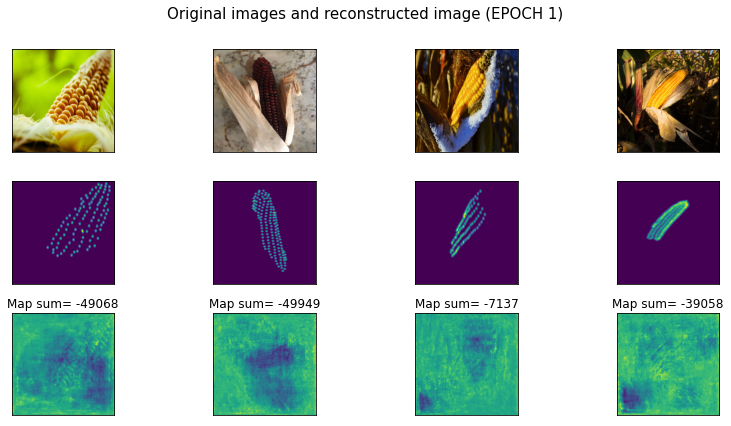

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [13:12<00:00, 396.36s/it]


Epoch: 2/2 -- Epoch Time: 400.45 s
---------------------------------
Train -- Loss: 56950.348
Val -- Loss: 40121.980


In [24]:
#writer = SummaryWriter(f"./runs/mobilenet_{learning_rate}_epochs_{max_epochs}_threshold_{1e-4}_scale_{1e5}")
writer = SummaryWriter()
train_loss, test_loss = my_functions.training_cycle(model,
                                                    device,
                                                    train_dataloader,
                                                    validation_dataloader,
                                                    validation_dataset,
                                                    loss_fn,
                                                    optimizer,
                                                    max_epochs,
                                                    writer,
                                                    verbose=True)
### To end TensorBoard writings
writer.close()

In [25]:
### Save model
os.makedirs('./Models', exist_ok=True)
epoch = 20
state = {'epoch': epoch + 1, 'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict(), }

torch.save(state,  f'Models/MobileNetV2_{learning_rate}_epochs_{max_epochs}_threshold_{1e-4}_scale_{1e5}.pth')

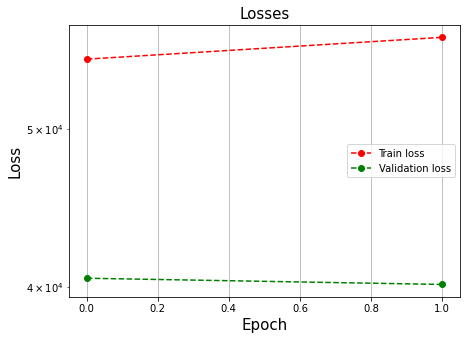

In [26]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train_loss, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test_loss, linestyle='--', marker='o', color='g', label='Validation loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
#plt.ylim(0,80)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

# Evaluation

## Loading of the saved model

In [30]:
def load_checkpoint(model, optimizer, filename='checkpoint.pth'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        #losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch

In [36]:
model, optimizer, start_epoch = load_checkpoint(model, optimizer, filename=f'Models/MobileNetV2_{learning_rate}_epochs_{max_epochs}_threshold_{1e-4}_scale_{1e5}.pth')
model = model.to(device)
# now individually transfer the optimizer parts...
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

=> loading checkpoint 'Models/MobileNetV2_0.0001_epochs_20_threshold_0.0001_scale_100000.0.pth'
=> loaded checkpoint 'Models/MobileNetV2_0.0001_epochs_20_threshold_0.0001_scale_100000.0.pth' (epoch 21)


## Real testing

In [27]:
### Evaluation on test set
model.eval()
with torch.no_grad():
    for data in test_dataloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, shapes, counts = data
        inputs = inputs.to(device)
        # forward 
        outputs = model(inputs)

In [28]:
idx = 2
input_image = inputs.detach().cpu().numpy()[idx]
predicted_map = outputs[idx]
original_map = labels[idx]

print("Predicted map:")
print("Shape",predicted_map.shape)
print("Min", predicted_map.min())
print("Maxp",predicted_map.max())
print("")
print("Original map:")
print("Shape",original_map.shape)
print("Min",original_map.min())
print("Maxp",original_map.max())

Predicted map:
Shape torch.Size([1, 320, 320])
Min tensor(-2.3176)
Maxp tensor(4.7174)

Original map:
Shape torch.Size([1, 320, 320])
Min tensor(0.)
Maxp tensor(248.6539)


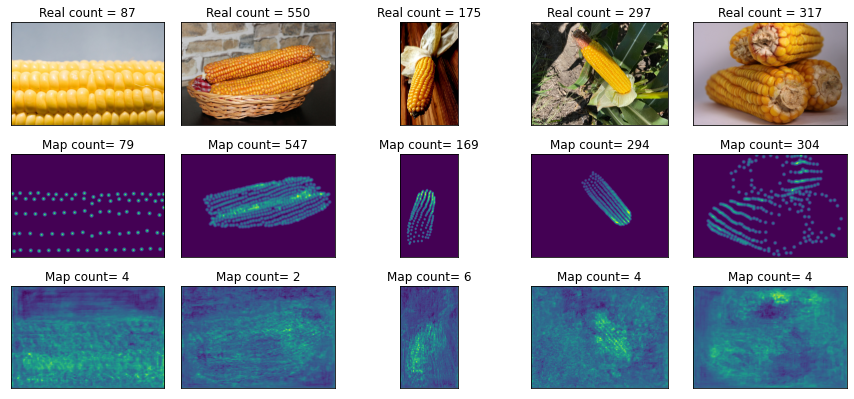

In [29]:
elements = [5,6,7,8,9]#random.sample([i for i in range(len(test_dataset))], 5)

fig, axs = plt.subplots(3, 5, figsize=(12,6))
fig.suptitle("",fontsize=15)
fig.subplots_adjust(top=0.88)
axs = axs.ravel()
for i in range(5):
    idx = elements[i]
    ### Move the images to the right shapes
    UP = nn.Upsample(size=(shapes[0][idx],shapes[1][idx]),mode='bilinear')
    img = inputs[idx]#.numpy().transpose(1, 2, 0)
    img = img[None, :]
    img = UP(img)
    img = img[0].numpy().transpose(1, 2, 0)

    label = labels[idx]#.numpy().transpose(1, 2, 0)
    label = label[None, :]
    label = UP(label)
    label = label[0].numpy().transpose(1, 2, 0)
    
    map_ = outputs[idx]#.numpy().transpose(1, 2, 0)
    map_ = map_[None, :]
    map_ = UP(map_)
    map_ = map_[0].numpy().transpose(1, 2, 0) 
    
    # Plot the reconstructed image
    axs[i].imshow(img)
    axs[i].set_title(f"Real count = {counts[idx]}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i+5].imshow(label)
    axs[i+5].set_title(f"Map count= {int(label.sum()/1e5)}")
    axs[i+5].set_xticks([])
    axs[i+5].set_yticks([])
    axs[i+10].imshow(map_)
    axs[i+10].set_title(f"Map count= {int(map_.sum()/1e5)}")
    axs[i+10].set_xticks([])
    axs[i+10].set_yticks([])
plt.tight_layout()
fig.subplots_adjust(top=0.88)

In [41]:
0.0005 - 5e-4

0.0

In [30]:
print(map_.min())
print(map_.max())
print(map_.mean())

print(label.min())
print(label.max())
print(label.mean())

-2.9610732
5.546233
0.19060966
0.0
235.15616
12.37334


### Evaluation metrics

In [31]:
label_count_list = []
map_count_list = []
for idx in [i for i in range(len(test_dataset))]:
    ### Move the images to the right shapes
    UP = nn.Upsample(size=(shapes[0][idx],shapes[1][idx]),mode='bilinear')

    label = labels[idx]#.numpy().transpose(1, 2, 0)
    label = label[None, :]
    label = UP(label)
    label = label[0].numpy().transpose(1, 2, 0)
    label_count = int(label.sum()/1e5)
    label_count_list.append(label_count)
    
    map_ = outputs[idx]#.numpy().transpose(1, 2, 0)
    map_ = map_[None, :]
    map_ = UP(map_)
    map_ = map_[0].numpy().transpose(1, 2, 0) 
    map_count = int(map_.sum()/1e5)
    map_count_list.append(map_count)

In [32]:
mae = np.sum(np.abs(np.array(label_count_list)-np.array(map_count_list)))/len(map_count_list)
print("MAE = ", mae)

rmse = np.sqrt(np.sum(np.abs(np.array(label_count_list)-np.array(map_count_list))**2)/len(map_count_list))
print("RMSE = ", rmse)

mape = np.sum(np.abs(np.array(label_count_list)-np.array(map_count_list))/np.array(label_count_list)) /len(map_count_list)
print("MAPE = ", mape)

MAE =  234.03225806451613
RMSE =  313.691393446777
MAPE =  0.9617663738932625
